In [24]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from tqdm import tqdm 
from torch.nn import init
import random

np.random.seed(21)

In [35]:
class Data:
    TABLE_SIZE = 1e8
    def __init__(self,training_data,min_freq,to_be_discard_size):
        self.training_data = training_data
        self.min_freq = min_freq
        self.to_be_discard_size = to_be_discard_size
        self.word2index = {}
        self.index2word = {}
        self.word_freq = {}
        self.sentence_count = 0 
        self.words_count = 0
        self.vocab_size = 0
        self.negatives = []
        self.subSampleTable = []
        self.negativePos = 0
        self.generateWords()
        self.generateNegatives()
        self.generateSubSampleTable()
        

    def generateWords(self):
        temp_dict = {}
        for sentence in self.training_data:
            sentence = sentence.split()
            if len(sentence) < 2:
                continue
            self.sentence_count += 1
            for word in sentence:
                if len(word) < 1:
                    continue
                self.words_count += 1
                if word not in temp_dict:
                    temp_dict[word] = 1
                else:
                    temp_dict[word] += 1
                if self.words_count %(1e6) == 0:
                    print("Processed {} M tokens".format(self.words_count))
        # indexing words for words , start, end and padding
        self.word2index = {'<PAD>':0,'<S>':1,'</S>':2}
        self.index2word = {0:'<PAD>',1:'<S>',2:'</S>'}
        self.word_freq = {'<PAD>':1,'<S>':1,'</S>':1}
        for word,cnt in temp_dict.items():
            if cnt >= self.min_freq:
                self.word2index[word] = len(self.word2index)
                self.index2word[len(self.index2word)] = word
                self.word_freq[word] = cnt

        self.vocab_size = len(self.word2index)
        print("Vocab size is {}".format(self.vocab_size))
        print("Total number of words {}".format(self.words_count))
        print("Total number of sentences {}".format(self.sentence_count))

    def generateNegatives(self):
        newFreqWords = []
        for word in self.word_freq:
            newFreqWords.append(self.word_freq[word])
        newFreqWords = np.array(newFreqWords)**0.75
        newFreqWords = newFreqWords/np.sum(newFreqWords)

        # self.negatives = np.random.choice(len(newFreqWords),size=int(Data.TABLE_SIZE),p=newFreqWords)
        self.negatives = np.random.choice(len(newFreqWords),size=int(Data.TABLE_SIZE),p=newFreqWords)
        # newFreqWords = np.round(newFreqWords*Data.TABLE_SIZE)
        # for w_id,cnt in enumerate(newFreqWords):
        #     self.negatives += [w_id]*int(cnt)

        # self.negatives = np.array(self.negatives)
        # np.random.shuffle(self.negatives)
        print("Negative samples generated")

    def generateSubSampleTable(self):
        # f = sqrt(t/f) + t/f
        fr = np.array(list(self.word_freq.values()))
        fr = fr/np.sum(fr)
        fr = np.sqrt(1e-3/fr) + 1e-3/fr
        self.subSampleTable = np.round(fr * self.TABLE_SIZE)
        print("Subsample table generated")

    def getNegativeSamples(self,target):
        negSamples = []
        while len(negSamples) < self.to_be_discard_size:
            neg = self.negatives[self.negativePos]
            self.negativePos = (self.negativePos + 1) % len(self.negatives)
            if neg not in negSamples and neg != target:
                negSamples.append(neg)

        if len(negSamples) != self.to_be_discard_size:
            return np.concatenate((negSamples,self.negatives[:self.to_be_discard_size-len(negSamples)]))
        return negSamples



In [36]:

data = Data(training_data[:100], min_freq=5, to_be_discard_size=5)
data.negatives.shape 


Vocab size is 258
Total number of words 7565
Total number of sentences 99
Negative samples generated
Subsample table generated


(100000000,)

In [37]:
class Word2vecDataLoader(Dataset):
    def __init__(self, data, windowSize):
        self.data = data
        self.windowSize = windowSize
        self.word2index = data.word2index
        self.index2word = data.index2word
        self.word_freq = data.word_freq
        self.subSampleTable = data.subSampleTable
        self.negatives = data.negatives
        self.length = data.sentence_count

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        sentence = self.data.training_data[idx].split()
        if len(sentence) < 2:
            # Can not return none as it will throw error
            if idx+1 == self.length:
                idx = 0
            return self.__getitem__(idx+1)
        sentence_ids = [self.word2index[word] for word in sentence if word in self.word2index and np.random.rand() < self.subSampleTable[self.word2index[word]]]
        padded_sent = [self.word2index['<S>']] + sentence_ids + [self.word2index['</S>']]
        cbowData = []
        szOneSide = self.windowSize//2
        for ind,word in enumerate(padded_sent):
            if ind == 0 or ind == len(padded_sent)-1:
                continue
            start = max(0,ind-szOneSide)
            end = min(len(padded_sent)-1,ind+szOneSide)
            context = [padded_sent[i] for i in range(start,end+1) if i != ind]
            if len(context) < 2*(szOneSide):
                context += [self.word2index['<PAD>']]*(2*(szOneSide)-len(context))
            
            cbowData.append((context,word,self.data.getNegativeSamples(word)))

        return cbowData
    
    @staticmethod
    def collate_fn(batches):
        targ_batch = [u for batch in batches for u,v,n in batch if len(batch) > 0]
        context_batch = [v for batch in batches for u,v,n in batch if len(batch) > 0]
        neg_batch = [n for batch in batches for u,v,n in batch if len(batch) > 0]

        return torch.LongTensor(context_batch),torch.LongTensor(targ_batch),torch.LongTensor(neg_batch)
    

class skipGramModule(nn.Module):
    def __init__(self,vocab_size,embedding_size):
        super(skipGramModule,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.targetEmbedding = nn.Embedding(vocab_size,embedding_size,sparse=True)
        self.contextEmbedding = nn.Embedding(vocab_size,embedding_size,sparse=True)
        initrange = 1.0/self.embedding_size
        init.uniform_(self.targetEmbedding.weight.data,-initrange,initrange)
        init.constant_(self.contextEmbedding.weight.data,0)

    def forward(self,context,target,negatives):
        trg_embedding = self.targetEmbedding(target)
        trg_embedding = torch.mean(trg_embedding,dim=1)
        context_embedding = self.contextEmbedding(context)
        neg_embedding = self.contextEmbedding(negatives)

        pos_score = torch.sum(
            torch.mul(trg_embedding, context_embedding), dim=1)
        pos_score = torch.clamp(pos_score,max=10,min=-10)
        pos_score = -F.logsigmoid(pos_score)

        neg_score = torch.bmm(neg_embedding,torch.unsqueeze(trg_embedding,2)).squeeze()
        neg_score = torch.clamp(neg_score,max=10,min=-10)
        neg_score = -torch.sum(F.logsigmoid(-neg_score),dim=1)

        return torch.mean(pos_score+neg_score)
    
    def embeddingSave(self,ind2word,output_file):
        embedding = self.targetEmbedding.weight.data.cpu().numpy()
        with open(output_file,'w') as f:
            f.write('{} {}\n'.format(len(ind2word),self.embedding_size))
            for word_id,word in ind2word.items():
                tmp = ' '.join(map(lambda x: str(x),embedding[word_id]))
                f.write('{} {}\n'.format(word,tmp))




In [39]:
EMBEDDING_DIM = 350
BATCH_SIZE = 128
WINDOW_SIZE = 9
EPOCHS = 10
LEARNING_RATE = 0.001
NEGATIVE_SAMPLES = 5
MIN_FREQ = 5

In [40]:
class CBOW:
    def __init__(self,training_data,output_file):
        self.data = Data(training_data,min_freq=MIN_FREQ,to_be_discard_size=NEGATIVE_SAMPLES)
        compData = Word2vecDataLoader(self.data,WINDOW_SIZE)
        self.dataloader = DataLoader(compData,batch_size=BATCH_SIZE,shuffle=True,collate_fn=compData.collate_fn)
        self.embedding_size = len(self.data.word2index)
        self.embedding_dim = EMBEDDING_DIM
        self.model = skipGramModule(self.embedding_size, self.embedding_dim)
        self.use_cuda = torch.cuda.is_available()
        self.output_file = output_file
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        if self.use_cuda:
            self.model.cuda()

    def train(self):
        optimizer = optim.SparseAdam(self.model.parameters(),lr=LEARNING_RATE)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,len(self.dataloader),eta_min=0.0001)
        for epoch in range(EPOCHS):
            total_loss = 0.0
            for i,(context,target,negatives) in enumerate(tqdm(self.dataloader)):
                if len(context) == 0:
                    continue
                cont = context.to(self.device)
                targ = target.to(self.device)
                neg = negatives.to(self.device)
                optimizer.step()
                optimizer.zero_grad()
                loss = self.model.forward(cont,targ,neg)
                loss.backward()
                scheduler.step()

                total_loss = total_loss*0.9 + loss.item()*0.1
                if i > 0 and i % 100 == 0:
                    print('Epoch: {} | Batch: {} | Loss: {}'.format(epoch,i,total_loss))
            print('Epoch: {} | Loss: {}'.format(epoch,total_loss))
        self.model.embeddingSave(self.data.index2word,self.output_file)

                

In [41]:
import pickle as pkl
training_data = []

with open('../../Data/smallData.pkl', 'rb') as fp:
    training_data = pkl.load(fp)


In [42]:
data = Data(training_data, min_freq=5, to_be_discard_size=5)

# size of word2index


Processed 1000000 M tokens
Processed 2000000 M tokens
Processed 3000000 M tokens
Processed 4000000 M tokens
Processed 5000000 M tokens
Processed 6000000 M tokens
Processed 7000000 M tokens
Processed 8000000 M tokens
Processed 9000000 M tokens
Processed 10000000 M tokens
Processed 11000000 M tokens
Processed 12000000 M tokens
Vocab size is 27687
Total number of words 12596513
Total number of sentences 99912
Negative samples generated
Subsample table generated


In [43]:
print(data.word2index["cavani"])

27196


In [44]:
output_file = 'wordEmb2.txt'

cbow = CBOW(training_data,output_file)
cbow.train()

Processed 1000000 M tokens
Processed 2000000 M tokens
Processed 3000000 M tokens
Processed 4000000 M tokens
Processed 5000000 M tokens
Processed 6000000 M tokens
Processed 7000000 M tokens
Processed 8000000 M tokens
Processed 9000000 M tokens
Processed 10000000 M tokens
Processed 11000000 M tokens
Processed 12000000 M tokens
Vocab size is 27687
Total number of words 12596513
Total number of sentences 99912
Negative samples generated
Subsample table generated


 13%|█▎        | 101/781 [00:41<04:08,  2.74it/s]

Epoch: 0 | Batch: 100 | Loss: 2.6577153497439974


 26%|██▌       | 201/781 [01:19<03:31,  2.74it/s]

Epoch: 0 | Batch: 200 | Loss: 2.517905265458138


 39%|███▊      | 301/781 [01:56<03:22,  2.37it/s]

Epoch: 0 | Batch: 300 | Loss: 2.5087405214015797


 51%|█████▏    | 401/781 [02:37<02:54,  2.18it/s]

Epoch: 0 | Batch: 400 | Loss: 2.4987315471427656


 64%|██████▍   | 501/781 [03:20<02:15,  2.07it/s]

Epoch: 0 | Batch: 500 | Loss: 2.4899131465229094


 77%|███████▋  | 601/781 [04:03<01:07,  2.68it/s]

Epoch: 0 | Batch: 600 | Loss: 2.4845638060608826


 90%|████████▉ | 701/781 [04:46<00:30,  2.62it/s]

Epoch: 0 | Batch: 700 | Loss: 2.478425919594225


100%|██████████| 781/781 [05:19<00:00,  2.44it/s]


Epoch: 0 | Loss: 2.4834255916509353


 13%|█▎        | 101/781 [00:43<05:04,  2.23it/s]

Epoch: 1 | Batch: 100 | Loss: 2.479977556832396


 26%|██▌       | 201/781 [01:26<03:48,  2.53it/s]

Epoch: 1 | Batch: 200 | Loss: 2.4739577251464664


 39%|███▊      | 301/781 [02:12<03:41,  2.16it/s]

Epoch: 1 | Batch: 300 | Loss: 2.455118105350693


 51%|█████▏    | 401/781 [02:58<02:44,  2.32it/s]

Epoch: 1 | Batch: 400 | Loss: 2.4390794587092692


 64%|██████▍   | 501/781 [03:42<01:51,  2.51it/s]

Epoch: 1 | Batch: 500 | Loss: 2.4086466850619823


 77%|███████▋  | 601/781 [04:26<01:10,  2.55it/s]

Epoch: 1 | Batch: 600 | Loss: 2.372907922133899


 90%|████████▉ | 701/781 [05:10<00:44,  1.79it/s]

Epoch: 1 | Batch: 700 | Loss: 2.332424470889743


100%|██████████| 781/781 [05:47<00:00,  2.25it/s]


Epoch: 1 | Loss: 2.298386001524284


 13%|█▎        | 101/781 [00:43<05:11,  2.18it/s]

Epoch: 2 | Batch: 100 | Loss: 2.2464837144845107


 26%|██▌       | 201/781 [01:28<04:11,  2.31it/s]

Epoch: 2 | Batch: 200 | Loss: 2.189824842775755


 39%|███▊      | 301/781 [02:13<03:22,  2.37it/s]

Epoch: 2 | Batch: 300 | Loss: 2.149915944420943


 51%|█████▏    | 401/781 [02:58<02:35,  2.44it/s]

Epoch: 2 | Batch: 400 | Loss: 2.12470366330592


 64%|██████▍   | 501/781 [03:41<02:06,  2.22it/s]

Epoch: 2 | Batch: 500 | Loss: 2.1026630104566704


 77%|███████▋  | 601/781 [04:26<01:15,  2.40it/s]

Epoch: 2 | Batch: 600 | Loss: 2.098591737978407


 90%|████████▉ | 701/781 [05:11<00:34,  2.34it/s]

Epoch: 2 | Batch: 700 | Loss: 2.0861775327234495


100%|██████████| 781/781 [05:48<00:00,  2.24it/s]


Epoch: 2 | Loss: 2.0866676526178174


 13%|█▎        | 101/781 [00:46<05:28,  2.07it/s]

Epoch: 3 | Batch: 100 | Loss: 2.072796616172608


 26%|██▌       | 201/781 [01:30<04:54,  1.97it/s]

Epoch: 3 | Batch: 200 | Loss: 2.0743730262002633


 39%|███▊      | 301/781 [02:15<04:02,  1.98it/s]

Epoch: 3 | Batch: 300 | Loss: 2.065278152982188


 51%|█████▏    | 401/781 [03:04<03:45,  1.69it/s]

Epoch: 3 | Batch: 400 | Loss: 2.0523639940960763


 64%|██████▍   | 501/781 [03:57<02:41,  1.73it/s]

Epoch: 3 | Batch: 500 | Loss: 2.027009828404436


 77%|███████▋  | 601/781 [04:55<01:52,  1.60it/s]

Epoch: 3 | Batch: 600 | Loss: 2.016677340291497


 90%|████████▉ | 701/781 [05:51<00:41,  1.92it/s]

Epoch: 3 | Batch: 700 | Loss: 1.9778901441514045


100%|██████████| 781/781 [06:37<00:00,  1.97it/s]


Epoch: 3 | Loss: 1.975253024231742


 13%|█▎        | 101/781 [00:54<05:56,  1.91it/s]

Epoch: 4 | Batch: 100 | Loss: 1.9508570886090197


 26%|██▌       | 201/781 [01:49<05:42,  1.69it/s]

Epoch: 4 | Batch: 200 | Loss: 1.9305047122891565


 39%|███▊      | 301/781 [02:46<04:37,  1.73it/s]

Epoch: 4 | Batch: 300 | Loss: 1.9191816355976403


 51%|█████▏    | 401/781 [03:41<03:16,  1.93it/s]

Epoch: 4 | Batch: 400 | Loss: 1.8964703803681913


 64%|██████▍   | 501/781 [04:41<02:47,  1.67it/s]

Epoch: 4 | Batch: 500 | Loss: 1.9135168073674593


 77%|███████▋  | 601/781 [05:40<02:01,  1.48it/s]

Epoch: 4 | Batch: 600 | Loss: 1.88992087541352


 90%|████████▉ | 701/781 [06:41<00:42,  1.88it/s]

Epoch: 4 | Batch: 700 | Loss: 1.8965608115292443


100%|██████████| 781/781 [07:28<00:00,  1.74it/s]


Epoch: 4 | Loss: 1.8883547159658716


 13%|█▎        | 101/781 [01:01<07:17,  1.56it/s]

Epoch: 5 | Batch: 100 | Loss: 1.876372133789308


 26%|██▌       | 201/781 [02:03<05:42,  1.69it/s]

Epoch: 5 | Batch: 200 | Loss: 1.882238356894894


 39%|███▊      | 301/781 [03:03<04:48,  1.67it/s]

Epoch: 5 | Batch: 300 | Loss: 1.8831520967274016


 51%|█████▏    | 401/781 [04:04<04:24,  1.44it/s]

Epoch: 5 | Batch: 400 | Loss: 1.8742499503968593


 64%|██████▍   | 501/781 [05:06<03:21,  1.39it/s]

Epoch: 5 | Batch: 500 | Loss: 1.870369364190031


 77%|███████▋  | 601/781 [06:07<01:38,  1.84it/s]

Epoch: 5 | Batch: 600 | Loss: 1.8520434147286544


 90%|████████▉ | 701/781 [07:06<00:44,  1.79it/s]

Epoch: 5 | Batch: 700 | Loss: 1.8542796737582226


100%|██████████| 781/781 [07:54<00:00,  1.64it/s]


Epoch: 5 | Loss: 1.8452349687234608


 13%|█▎        | 101/781 [00:58<07:44,  1.46it/s]

Epoch: 6 | Batch: 100 | Loss: 1.8283643868883617


 26%|██▌       | 201/781 [02:01<05:29,  1.76it/s]

Epoch: 6 | Batch: 200 | Loss: 1.8201968634206318


 39%|███▊      | 301/781 [03:04<05:20,  1.50it/s]

Epoch: 6 | Batch: 300 | Loss: 1.80785054325484


 51%|█████▏    | 401/781 [04:05<04:00,  1.58it/s]

Epoch: 6 | Batch: 400 | Loss: 1.8059138815078661


 64%|██████▍   | 501/781 [05:07<03:08,  1.48it/s]

Epoch: 6 | Batch: 500 | Loss: 1.7998382294747757


 77%|███████▋  | 601/781 [06:10<02:07,  1.41it/s]

Epoch: 6 | Batch: 600 | Loss: 1.7936337324671747


 90%|████████▉ | 701/781 [07:12<00:49,  1.63it/s]

Epoch: 6 | Batch: 700 | Loss: 1.7914700814833888


100%|██████████| 781/781 [08:02<00:00,  1.62it/s]


Epoch: 6 | Loss: 1.792589846140953


 13%|█▎        | 101/781 [01:02<06:26,  1.76it/s]

Epoch: 7 | Batch: 100 | Loss: 1.7803494073941846


 26%|██▌       | 201/781 [02:02<05:53,  1.64it/s]

Epoch: 7 | Batch: 200 | Loss: 1.7822291059345954


 39%|███▊      | 301/781 [03:04<04:44,  1.69it/s]

Epoch: 7 | Batch: 300 | Loss: 1.7841126536828393


 51%|█████▏    | 401/781 [04:08<04:10,  1.51it/s]

Epoch: 7 | Batch: 400 | Loss: 1.7792789486287637


 64%|██████▍   | 501/781 [05:07<03:22,  1.38it/s]

Epoch: 7 | Batch: 500 | Loss: 1.7797901489862247


 77%|███████▋  | 601/781 [06:07<01:44,  1.73it/s]

Epoch: 7 | Batch: 600 | Loss: 1.7648973370788823


 90%|████████▉ | 701/781 [07:07<00:43,  1.84it/s]

Epoch: 7 | Batch: 700 | Loss: 1.7681215371982844


100%|██████████| 781/781 [07:54<00:00,  1.65it/s]


Epoch: 7 | Loss: 1.7550887399960013


 13%|█▎        | 101/781 [01:02<06:57,  1.63it/s]

Epoch: 8 | Batch: 100 | Loss: 1.752642884914664


 26%|██▌       | 201/781 [02:02<05:45,  1.68it/s]

Epoch: 8 | Batch: 200 | Loss: 1.7453495823072336


 39%|███▊      | 301/781 [03:03<05:33,  1.44it/s]

Epoch: 8 | Batch: 300 | Loss: 1.742332700989447


 51%|█████▏    | 401/781 [04:05<03:53,  1.63it/s]

Epoch: 8 | Batch: 400 | Loss: 1.7380081734897412


 64%|██████▍   | 501/781 [05:09<02:44,  1.71it/s]

Epoch: 8 | Batch: 500 | Loss: 1.730743042675602


 77%|███████▋  | 601/781 [06:13<01:53,  1.59it/s]

Epoch: 8 | Batch: 600 | Loss: 1.7330210894259845


 90%|████████▉ | 701/781 [07:17<00:49,  1.61it/s]

Epoch: 8 | Batch: 700 | Loss: 1.723226530833851


100%|██████████| 781/781 [08:06<00:00,  1.60it/s]


Epoch: 8 | Loss: 1.728093405214064


 13%|█▎        | 101/781 [01:02<06:39,  1.70it/s]

Epoch: 9 | Batch: 100 | Loss: 1.7167477666955266


 26%|██▌       | 201/781 [02:04<05:35,  1.73it/s]

Epoch: 9 | Batch: 200 | Loss: 1.7196290293211998


 39%|███▊      | 301/781 [03:07<05:07,  1.56it/s]

Epoch: 9 | Batch: 300 | Loss: 1.7216666129826155


 51%|█████▏    | 401/781 [04:09<03:36,  1.75it/s]

Epoch: 9 | Batch: 400 | Loss: 1.716419277597416


 64%|██████▍   | 501/781 [05:12<03:02,  1.53it/s]

Epoch: 9 | Batch: 500 | Loss: 1.716575164840054


 77%|███████▋  | 601/781 [06:09<01:38,  1.83it/s]

Epoch: 9 | Batch: 600 | Loss: 1.7149510196111966


 90%|████████▉ | 701/781 [07:02<00:44,  1.81it/s]

Epoch: 9 | Batch: 700 | Loss: 1.7161397725285263


100%|██████████| 781/781 [07:43<00:00,  1.69it/s]


Epoch: 9 | Loss: 1.7053488639564212


In [8]:
!pip3 install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 4.3 MB/s eta 0:00:0000:0100:01


In [47]:
import gensim
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import argparse

def plot_top10_words(word, cbow_own):

    def tsne_plot(results):
        words = [x[0] for x in results]
        embeds = [x[1] for x in results]
        words = np.array(words)
        embeds = np.array(embeds)
        tsne_model = TSNE(init='pca',perplexity = 9,random_state=42)
        res_embeds = tsne_model.fit_transform(embeds)
        x_axis = res_embeds[:,0]
        y_axis = res_embeds[:,1]
            
        plt.figure(figsize=(10, 10)) 
        for i in range(len(x_axis)):
            plt.scatter(x_axis[i], y_axis[i])
            plt.annotate(words[i], xy=(x_axis[i], y_axis[i]), xytext=(
                5, 2), textcoords='offset points', ha='right', va='bottom')
        plt.savefig('./Results/'+word+'.png')
    
    similar_words = cbow_own.most_similar(positive=[word], topn = 10)
    res = {}
    for i, embed in tqdm(enumerate(similar_words)):
        res[embed[0]] = [embed[1], cbow_own[embed[0]]]

    results = []
    for t in sorted(res.items(), key=lambda item: item[1][0], reverse=True)[0:10]:
        results.append([t[0], t[1][1]])

    print('Word: ', word)
    # print(results)
    print('Top 10 similar words: ', [x[0] for x in results])
    tsne_plot(results)



cbow_own = gensim.models.KeyedVectors.load_word2vec_format('wordEmb2.txt', binary=False)


10it [00:00, 52626.15it/s]


Word:  ship
Top 10 similar words:  ['mount', 'raid', 'roof', 'plane', 'tower', 'egg', '747', 'corporation', 'patrol', 'subway']


10it [00:00, 46192.78it/s]


Word:  begin
Top 10 similar words:  ['connect', 'proceed', 'communicate', 'grips', 'react', 'sympathize', 'breathe', 'compete', 'cope', 'identify']


10it [00:00, 106454.42it/s]


Word:  well
Top 10 similar words:  ['nicely', 'poorly', 'badly', 'tastefully', 'beautifully', 'professionally', 'perfectly', 'flawlessly', 'brilliantly', 'cheaply']


10it [00:00, 93832.30it/s]


Word:  great
Top 10 similar words:  ['wonderful', 'fantastic', 'terrific', 'fine', 'good', 'fabulous', 'superb', 'marvelous', 'solid', 'stellar']


10it [00:00, 60349.70it/s]


Word:  my
Top 10 similar words:  ['mine', 'your', 'everyones', 'our', 'goose', 'schindlers', 'her', 'his', 'anyones', 'their']


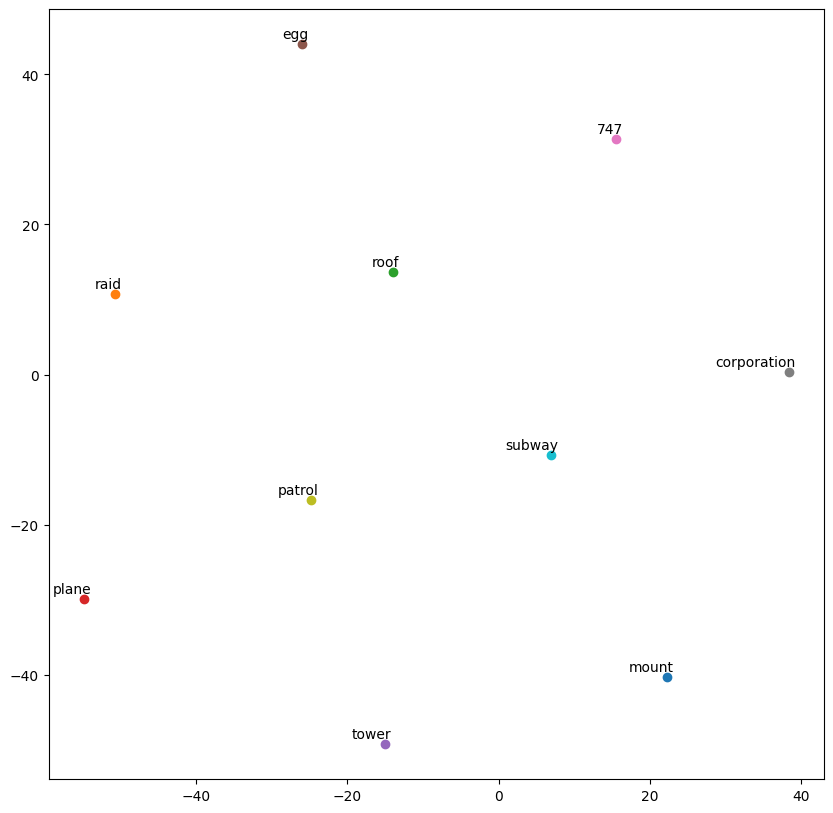

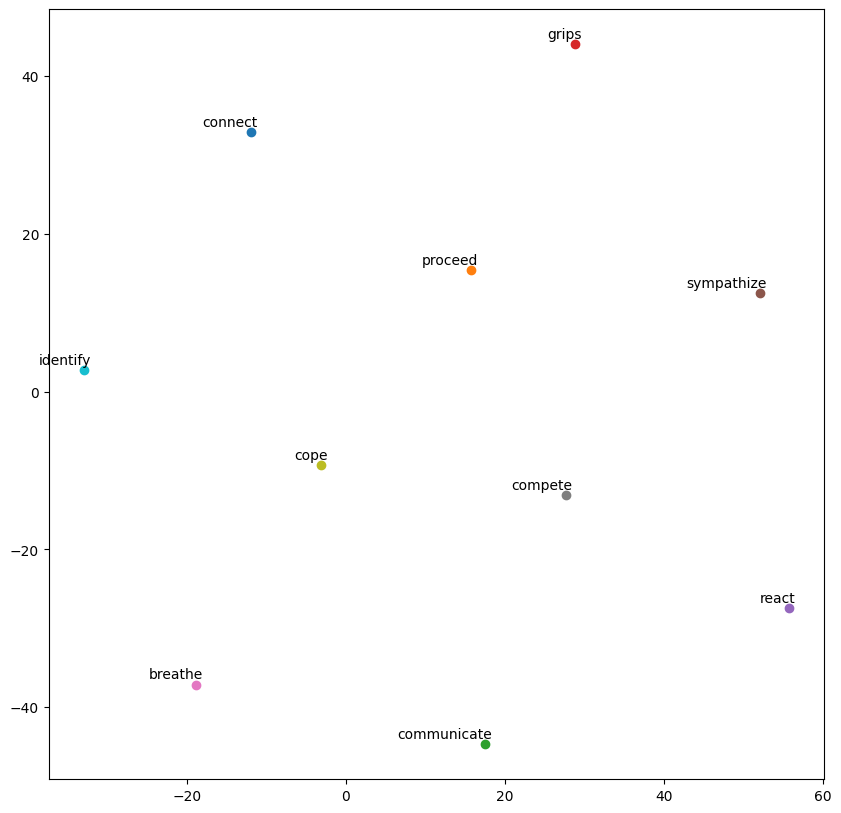

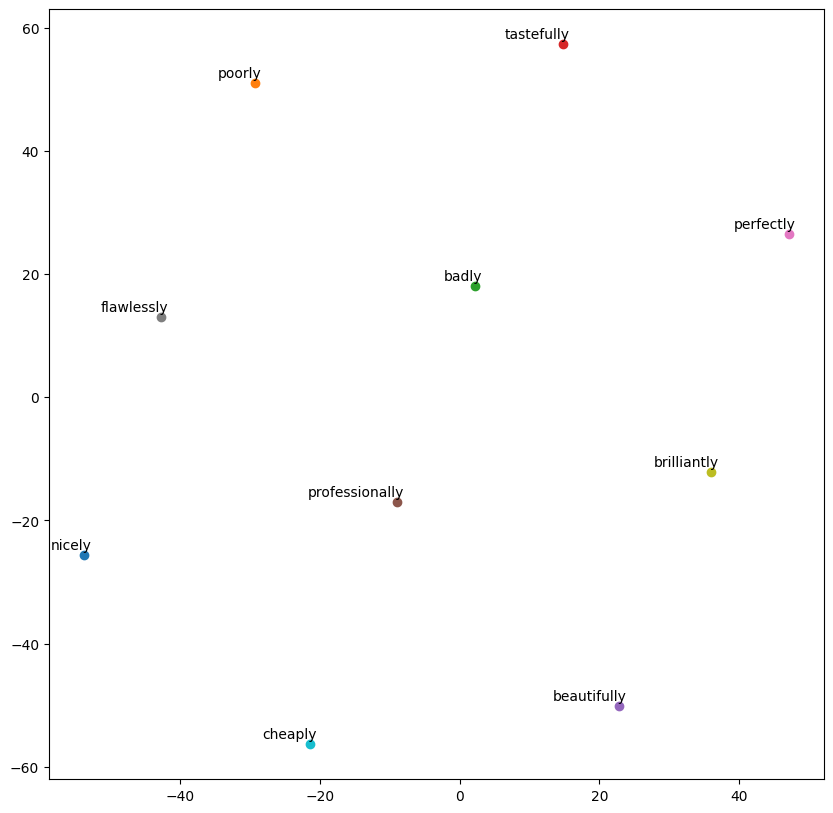

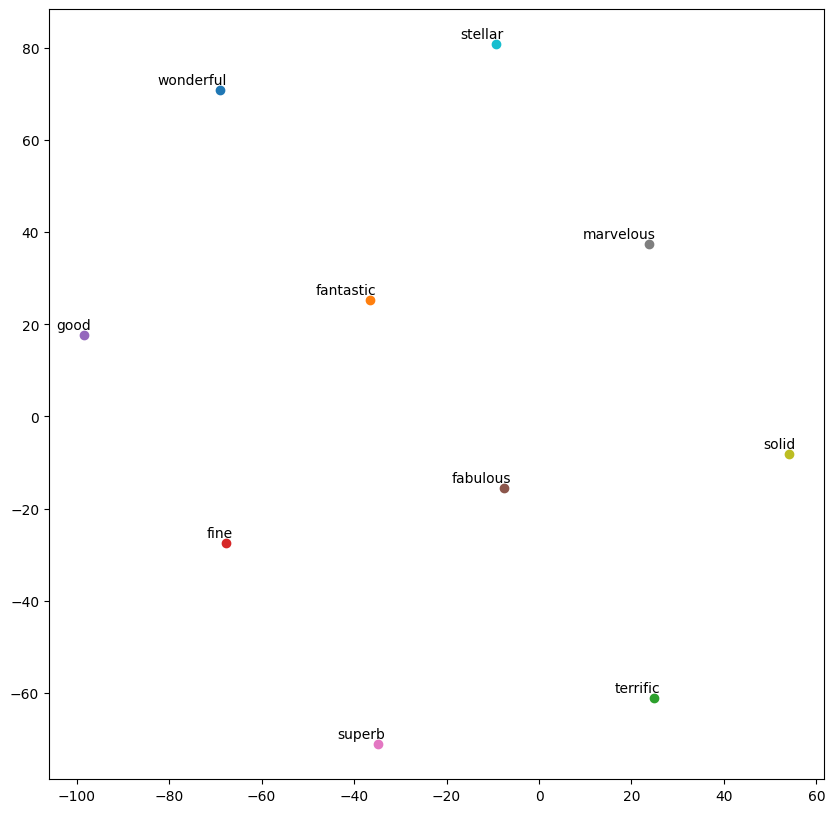

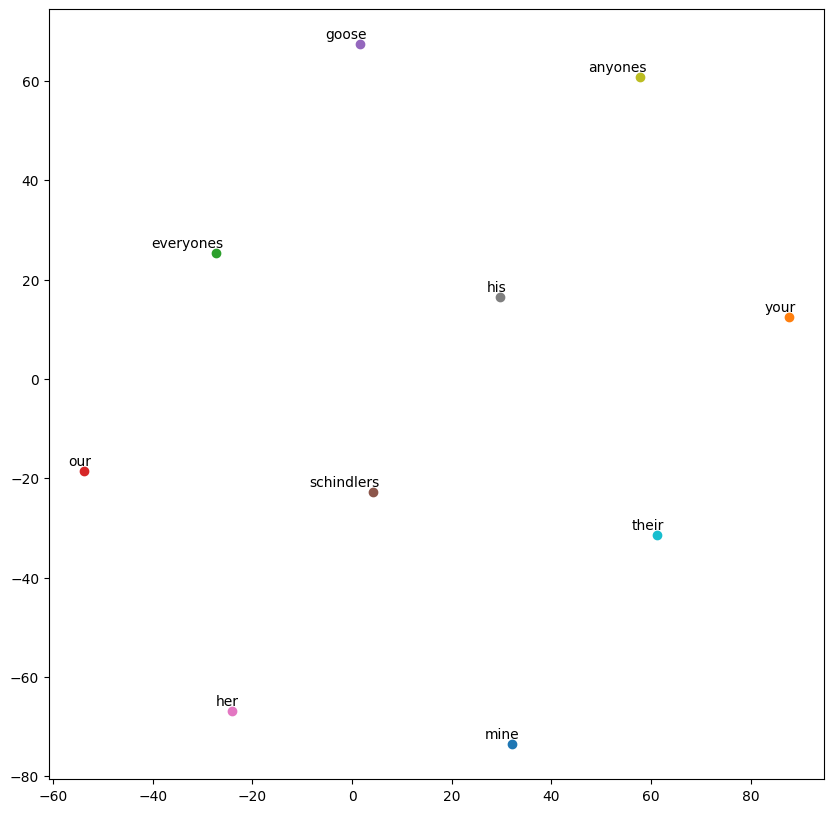

In [48]:

words = ['ship', 'begin', 'well', 'great', 'my']
for word in words:
    plot_top10_words(word, cbow_own)


10it [00:00, 12206.94it/s]


Word:  speak
Top 10 similar words:  ['respond', 'react', 'apply', 'distinguish', 'utilize', 'offend', 'fathom', 'gravitate', 'speculate', 'reacting']


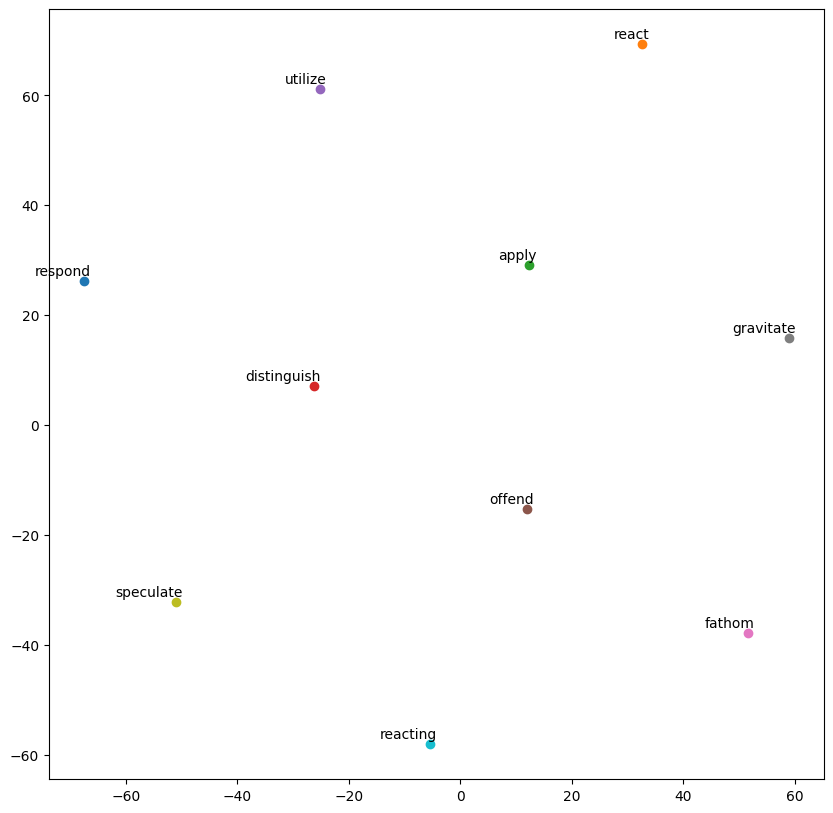

In [54]:
plot_top10_words('speak', cbow_own)